In [81]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import load_model
import os, sys
import cv2
%matplotlib inline

In [12]:
ROOT_DIR = 'E:\\PROJECTS AND CODES\\AI AND DATA SCIENCE\\DATA-SETS\\ranzr-clip-placement'
DATA_SETS = ROOT_DIR + '\\datasets'
SCRIPTS = ROOT_DIR + '\\scripts'

In [13]:
datasets_list = os.listdir(DATA_SETS)
datasets_list

['sample_submission.csv',
 'test',
 'test_tfrecords',
 'train',
 'train.csv',
 'train_annotations.csv',
 'train_tfrecords']

In [27]:
train = os.path.join(DATA_SETS, 'train')
submission_csv = os.path.join(DATA_SETS,'sample_submission.csv')
test = os.path.join(DATA_SETS, 'test')

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


In [30]:
train_df = pd.read_csv(DATA_SETS+'\\train.csv')
print(f'Train Data CSV: {train_df.shape[0]}')
train_df.head()

Train Data CSV: 30083


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [ ]:
sub_df = pd.read_csv(submission)
print(f'Sub CSV: {sub_df.shape[0]}')
sub_df.head()

In [58]:
# label column names
label_cols = list(sub_df.columns[1:])
image_labels = train_df[label_cols].values # will be used for train validation splitting

In [59]:
# Count up the number of instances of each class (drop non-class columns from the counts) 
class_counts = train_df.sum().drop(['StudyInstanceUID','PatientID'])

In [62]:
# we plot the distribution of patients to check if there is any class imbalance in the dataset
def plot_class_distributions(values, index):
    sns.barplot(x=values, y=index)
    plt.title('Distribution of classes for the patients')
    plt.xlabel('Patient Count', fontsize=15)
    plt.ylabel('Catheter Position', fontsize=15)
    plt.show()

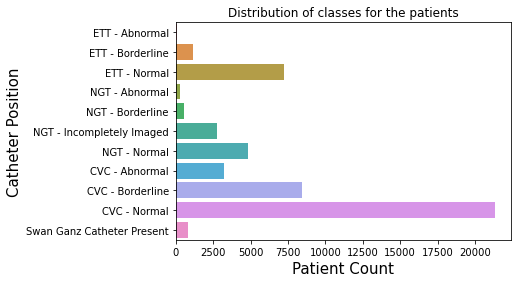

In [63]:
plot_class_distributions(class_counts.values, class_counts.index)

In [115]:
train_images = ROOT_DIR + "\\train\\" + train_df['StudyInstanceUID'] + '.jpg'   
test_images = ROOT_DIR + "\\test\\" + sub_df['StudyInstanceUID'] + '.jpg'
len(test_images)

3582

In [99]:
data_image = os.path.join(DATA_SETS, "train_annotations.csv")
data_image = pd.read_csv(data_image)
data_image.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [105]:
# display images randomly on a grid
def display_images(image_ids, labels):
    fig = plt.figure(figsize = (16,12))
    
    for index, (image_id, label) in enumerate(zip(image_ids,labels)):
        plt.subplot(3,3, index+1)
        image = image_id + '.jpg'
        image = mpimg.imread(os.path.join(DATA_SETS, "train", image))
        plt.title(label, fontsize=12)
        plt.imshow(image,cmap='Greys')
    
    fig.tight_layout()
    plt.show()    
        

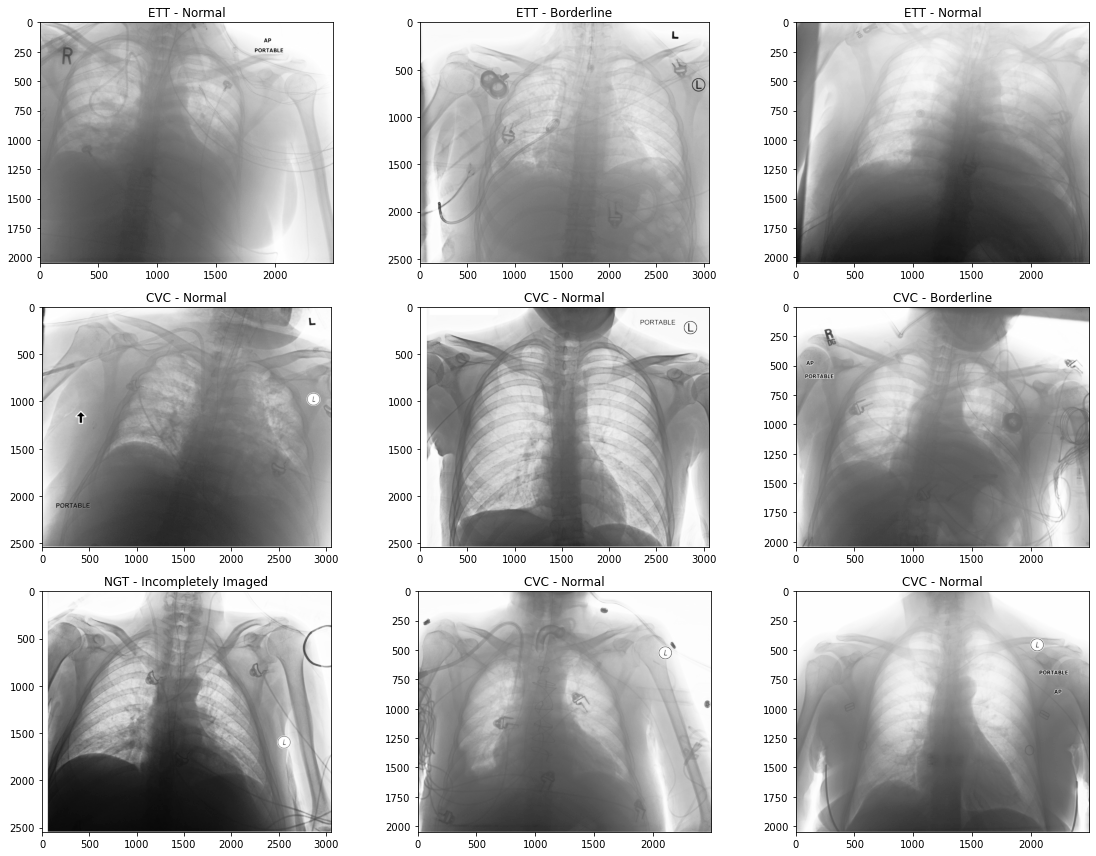

In [107]:
tmp_train = data_image.sample(9)
image_ids = tmp_train["StudyInstanceUID"].values
labels = tmp_train['label'].values
display_images(image_ids, labels)

In [108]:
# now we check for any kinds of data leakage between any two data sets, train-test, train-valid, valid-test
def check_for_leakage(df1, df2, patient_col):
    
    df1_unique = set(df1[patient_col])
    df2_unique = set(df2[patient_col])
    
    common_patients = df1_unique.intersection(df2_unique)
    
    return True if len(common_patients) > 0 else False
    
    

In [ ]:
check_for_leakage(train_df, test_images, '')